---
# Create graphic for oil spill fate by "location category" 
i.e. water column, water surface, beach, and air (evaporation)

---

The monte carlo runs were completed on Compute Canada's supercomputer, `Graham` and this code is intended to be used on that system.  It requires initialization of a Virtual Environment.  See `/home/rmueller/projects/def-allen/rmueller/graham-jupyter-env.txt`.

First initiate a compute node (no heavy-lifting in this example) with: 
```
salloc --time=1:00:00 --ntasks=1 --cpus-per-task=1 --mem-per-cpu=1024M --account=rrg-allen
```
Activate `VENV` with:
```
module load python/3.8.2
source ~/venvs/jupyter/bin/activate
```
Deactivate `VENV` with:
```
deactivate
```
If the `jupyter` `VENV` is not yet setup, install it with:
```
module load python/3.8.2
python3 -m virtualenv --no-download ~/venvs/jupyter
source ~/venvs/jupyter/bin/activate
python3 -m pip install --no-index --upgrade pip
python3 -m pip install -r /home/rmueller/projects/def-allen/rmueller/graham-jupyter-env.txt
```

This environment is setup to allow user to initiate a remote window using:
```
jupyter lab --no-browser --ip $(hostname -f)
```

#### Steps for generating this graphic
1. Oil type is identified by the Lagrangian output file name in [create_SOILED_sro_runlist.ipynb](https://github.com/MIDOSS/analysis-rachael/blob/main/notebooks/monte_carlo/create_SOILED_sro_runlist.ipynb). At this point, I preserve all oil type categories that I created from the Department of Ecology data. 
2. Either In[5] or In[7] is used to open existing files or create new files in which mass information is gathered from runs and organized by oil type.  It's not a very clean method, but it's what I have right now. The script for sorting oil mass is called aggregate_sro_mass_byoil in [aggregate_sro_mass.py](https://github.com/MIDOSS/analysis-rachael/blob/main/scripts/monte_carlo/aggregate_sro_mass.py), line 157.  An oil dictionary is used to group the mass balance output values in the *.sro files (see line 209 of `aggregate_sro_mass.py`). Some of the variables are then grouped to create the surface, water column, beach, and air locations seen there.  

In [1]:
import sys
sys.path.insert(1, '../../../scripts/')
sys.path.insert(1, '../../../scripts/monte_carlo')
from aggregate_sro_mass import aggregate_sro_mass_byoil
sys.path.insert(1, '../MEOPAR2022/')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import datetime
from midoss_utils import *
import yaml
import time
import glob
# compress helps to extract values from list based on the value in a column
# e.g. dissolution < 0.0
from itertools import compress
# graphics style
plt.style.use(r"../MEOPAR2022/meopar2022_matplotlibrc.template")

# predefined naming conventions
import MEOPAR2022_setup as oil


MIDOSScolors={
    'ANS': 'darkslategrey',
    'Bunker-C':'teal',
    'Dilbit':'slategrey',
    'Diesel':'darkgoldenrod',
}

In [2]:
oil.colors

['darkslategrey',
 'teal',
 'slategrey',
 'cornflowerblue',
 'cornflowerblue',
 'cornflowerblue',
 'teal']

In [3]:
color_dict = {"MEvaporated": "darkolivegreen",
              "MDispersed": "darkblue", 
              "MDissolved": "royalblue", 
              "MBio": "skyblue",
              "MFloating": "saddlebrown", 
             "MBeached": "chocolate", 
             "MInitial": "grey",
             "MTotal":"magenta"}
oil_dict = {"akns":"ANS",
            "all":"all",
           "bunker":"Bunker-C",
           "diesel":"Diesel",
           "dilbit":"Dilbit",
           "gas":"Diesel",
           "jet":"Diesel",
           "other":"Bunker-C"}
cols_plot = ["MEvaporated", "MDispersed",  "MDissolved", "MBio", "MFloating", "MBeached", "MInitial","MTotal"]
oil_types = ["Bunker-C", "Diesel", "Dilbit", "ANS"]
# Select True to re-run cataloguing code and False to open "input_file" instead
catalogue_flag = False

### Directory paths and file names

In [4]:
# directories
output_dir =Path('/scratch/rmueller/MIDOSS/Results')
graphics_dir = Path('/home/rmueller/projects/def-allen/rmueller/MIDOSS/graphics/SSEC2022')

# file path for the dictionay containing the list of .sro filenames by oil
file_paths = '/scratch/rmueller/MIDOSS/Results/MOHID_massbalance_try3_10042022_18:37:14.yaml'

# file paths with information extracted from the files listed in the above .yaml
input_file_oil = output_dir / 'SOILED_massbalance_byoil_10042022_19:18:55.yaml'
input_file_all = output_dir / 'SOILED_massbalance_all_24022022_14:13:17.yaml'

# spills file
spill_dir = Path(
    '/scratch/allen/MIDOSS/'
)
spill_file = spill_dir/'SalishSea_oil_spills_try3.csv'

### Open existing mass aggregation file

In [5]:
with open(input_file_oil) as file:
    sro = yaml.safe_load(file)

### OR...create new mass aggregation file
- MInitial is calculated here.  It's the first timestep, and I confirmed that it's the spill volume.  This code could be simplified.  MInitial = data['MassOil'][1].item, but I confirmed that MInitial - data['MassOil'][1].item() = 0

In [6]:
### Verify that MInitial is the same as the first output for MassOil (it is)
# with open(file_paths) as file:
#     fnames = yaml.safe_load(file)
# for fname in fnames['diesel']:
#     data = pandas.read_csv(fname, sep="\s+", skiprows=4)
#     # remove first entry of NaN values
#     data = data.drop([0], axis=0)
#     length = len(data)
#     if length>4:
#         data = data.drop([length-3, length-2, length-1, length], axis=0)
#         data_last = data[-1:]
#         MBeached = (data['VolOilBeached'][1].item()*data['Density'][1].item()/
#             (1-data['VWaterContent'][1].item())*
#             (1-data['MWaterContent'][1].item()))
#         MInitial = (
#             data['MEvaporated'][1].item() + data['MDispersed'][1].item() + 
#             data['MDissolved'][1].item() + data['MBio'][1].item() + 
#             data['MassOil'][1].item() + MBeached
#         )
#         print(MInitial, MBeached, MInitial - data['MassOil'][1].item())

In [7]:
#input_yaml = '/scratch/rmueller/MIDOSS/Results/MOHID_massbalance_13022022_18:10:19.yaml'
# output_dir = Path('/scratch/rmueller/MIDOSS/Results')
# sro = aggregate_sro_mass_byoil(file_paths, output_dir)

In [8]:
df={}
df['ANS'] = pandas.DataFrame(sro['ANS'])
df['Bunker-C'] = pandas.DataFrame(sro['Bunker-C'])
df['Diesel'] = pandas.DataFrame(sro['Diesel'])
df['Dilbit'] = pandas.DataFrame(sro['Dilbit'])

### calculate geometric mean of mass values
- total (MEvaporated + MDispersed + MDissolved + MBio + MSurface + MBeached)
- surface (MassOil)
- beached (MBeached)
- water column (MDispersed, MDissolved, MBio)

In [9]:
# specify key words
oil_types = ['ANS', 'Bunker-C', 'Diesel', 'Dilbit']
#oil_types = ['ANS', 'Bunker-C', 'Diesel']
locations = ['water','sfc','beach','air']
# initialize dictionaries
water = {}
sfc = {}
beach = {}
air = {}
time={}
initial={}
final={}
tmp={}
mass_max = {}
combined_mass = {}
total_mass = {}
# create dictionary of mean values (update code later to use this method for geometric mean values!)
mean = {}
for location in locations:
    mean[location] = {}
    final[location]={}
    for oil in oil_types:
        final[location][oil]=[]
# cataloge information by oil type
for oil in oil_types:
    print(oil)
    # number of spills with positive dissolution (note: for Bunker but applied to all)
    Nspills = len(df[oil]['MDissolved'].loc[df[oil]['MDissolved']>0])
    water_col = (df[oil]['MDispersed'].loc[df[oil]['MDissolved']>0] + 
        df[oil]['MDissolved'].loc[df[oil]['MDissolved']>0] + 
        df[oil]['MBio'].loc[df[oil]['MDissolved']>0])
    # remove values associated with bogus dissolution/evaporation/surface
    surface = df[oil]['MassOil'].loc[df[oil]['MDissolved']>0]
    beached = df[oil]['MBeached'].loc[df[oil]['MDissolved']>0]
    evaporated = df[oil]['MEvaporated'].loc[df[oil]['MDissolved']>0]
    # get vectors of spill duration 
    time[oil]=df[oil]['days_since_spill'].loc[df[oil]['MDissolved']>0]
    # calculate geometric means
    water[oil]=numpy.exp(numpy.log(water_col.loc[water_col>0]).sum()/ Nspills)
    sfc[oil]=numpy.exp(numpy.log(surface.loc[surface>0]).sum()/ Nspills)
    beach[oil]=numpy.exp(numpy.log(beached.loc[beached>0]).sum()/ Nspills)
    air[oil]=numpy.exp(numpy.log(evaporated.loc[evaporated>0]).sum()/ Nspills)
    # Add up total, initial oil mass
    initial[oil]=df[oil]['MInitial'].loc[df[oil]['MDissolved']>0]
    # Save array of final, total oil mass for all runs
    final['water'][oil]=water_col
    final['sfc'][oil]=surface
    final['beach'][oil]=beached
    final['air'][oil]=evaporated
    # calculate means
    mean['water'][oil] = water_col.sum()/ Nspills
    mean['sfc'][oil] = surface.sum()/ Nspills
    mean['beach'][oil] = beached.sum()/ Nspills
    mean['air'][oil] = evaporated.sum()/Nspills
    # all but evaporation
    combined_mass[oil] = water_col.sum() + surface.sum() + beached.sum()
    total_mass[oil] = combined_mass[oil] + evaporated.sum()

ANS
Bunker-C
Diesel
Dilbit


## Evaluate spills that are included in this analysis

### spill duration and number of spills

In [10]:
print('*** Spill duration and [number of spills] included in analysis ***') 
for oilname in [*time]:
    print(f'{oilname}: {numpy.median(time[oilname]):2.2f}, {numpy.min(time[oilname]):2.2f}, {numpy.mean(time[oilname]):2.2f} [{len(time[oilname])}]')

*** Spill duration and [number of spills] included in analysis ***
ANS: 7.00, 0.79, 6.65 [55]
Bunker-C: 7.00, 0.08, 5.36 [2425]
Diesel: 6.54, 0.08, 4.47 [4378]
Dilbit: 1.21, 1.21, 1.21 [1]


### verify number of spills in input dictionary

In [11]:
total=0
for oilname in [*sro]:
    print(f'{oilname}: {len(sro[oilname]["MassOil"])} spills')
    total+=len(sro[oilname]["MassOil"])
print('---------------')
print(f'TOTAL: {total}')

ANS: 55 spills
Bunker-C: 2559 spills
Diesel: 4378 spills
Dilbit: 1 spills
---------------
TOTAL: 6993


### verify number of .sro files listed in .sro file dictionary (before information is extracted)

In [12]:
with open(file_paths) as file:
    path_list = yaml.safe_load(file)
print('*** Number of .sro files ***')
total=0
for oilname in [*path_list]:
    print(f'{oilname}: {len(path_list[oilname])} .sro files')
    total+=len(path_list[oilname])
print('---------------')
print(f'TOTAL: {total}')

*** Number of .sro files ***
akns: 55 .sro files
all: 6995 .sro files
bunker: 2505 .sro files
diesel: 4300 .sro files
dilbit: 1 .sro files
gas: 60 .sro files
jet: 20 .sro files
other: 54 .sro files
---------------
TOTAL: 13990


### verify number of spills with dissolved <0, vs >0 and ==0

In [13]:
for oil in oil_types:
    print(oil)
    print(f"  \_ {len(df[oil]['MDissolved'].loc[df[oil]['MDissolved']>0])}, ", 
          f"{len(df[oil]['MDissolved'].loc[df[oil]['MDissolved']<0])}, ",
          f"{len(df[oil]['MDissolved'].loc[df[oil]['MDissolved']==0])}"
         )

ANS
  \_ 55,  0,  0
Bunker-C
  \_ 2425,  134,  0
Diesel
  \_ 4378,  0,  0
Dilbit
  \_ 1,  0,  0


### list mass results for runs with MDissolved < 0

In [14]:
df['Bunker-C'].loc[df['Bunker-C']['MDissolved']<0].sort_values(by='MDissolved')

,Density,MBeached,MBio,MDispersed,MDissolved,MEvaporated,MInitial,MWaterContent,MassOil,VWaterContent,VolOilBeached,days_since_spill,month
1116,993.705857,2870.689687,0.000000,375.823950,-4230.494519,6.131583e+06,6.131583e+06,0.0,983.808499,0.0,2.888873,7.000000,5
1121,993.114007,898.056828,0.003210,255.277911,-3935.479862,5.704973e+06,5.704974e+06,0.0,2747.339866,0.0,0.904284,7.000000,4
1765,992.997109,1729.463549,0.000732,0.103566,-1955.203787,2.833744e+06,2.833745e+06,0.0,42.798029,0.0,1.741660,7.000000,10
2523,992.031231,491292.415652,0.126763,7.036632,-1838.246858,4.030807e+06,4.520869e+06,0.0,16.244096,0.0,495.238860,7.000000,5
1267,993.277117,1481.065028,0.004958,2.696224,-1836.178496,2.661758e+06,2.661759e+06,0.0,352.545962,0.0,1.491089,7.000000,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,993.958470,128.377927,1.126145,30.505485,-0.105397,2.917279e+02,4.521432e+02,0.0,0.094383,0.0,0.129158,7.000000,4
1518,993.501658,30136.384049,5.808548,20.551765,-0.057875,1.335092e+03,3.147527e+04,0.0,0.065113,0.0,30.333502,7.000000,11
2107,993.814625,452.722239,0.091974,2.889770,-0.026034,1.116507e+02,5.675472e+02,0.0,0.020844,0.0,0.455540,3.166667,4
2460,993.027945,912.766649,0.000000,0.000000,-0.012801,7.758407e+01,9.908573e+02,0.0,0.012659,0.0,0.919175,0.375000,10


### list filepaths with negative dissolution

In [15]:
[*path_list]

['akns', 'all', 'bunker', 'diesel', 'dilbit', 'gas', 'jet', 'other']

In [16]:
[*df]

['ANS', 'Bunker-C', 'Diesel', 'Dilbit']

In [17]:
print(f"Length of Bunker-C filename list: {len(path_list['bunker']) + len(path_list['other'])}")
print(f"Length of MDissolved values: {len(df['Bunker-C']['MDissolved'])}")

Length of Bunker-C filename list: 2559
Length of MDissolved values: 2559


In [18]:
len(numpy.where(df['Bunker-C']['MDissolved']<0)[0])

134

In [19]:
#numpy.where(df['Bunker-C']['MDissolved']<0)[0].tolist()

In [20]:
bunker_c_paths = path_list['bunker']+path_list['other']
len(bunker_c_paths)

2559

In [21]:
negative_paths = [bunker_c_paths[idx] for idx in numpy.where(df['Bunker-C']['MDissolved']<0)[0].tolist()]
len(negative_paths)

134

In [22]:
with open(output_dir/'negative_dissolution_files.txt', 'w') as file_handler:
    for item in negative_paths:
        file_handler.write("{}\n".format(item))

In [23]:
print('Water: ', water)
print('Surface: ', sfc)
print('Beach: ', beach)
print('Air: ', air)

Water:  {'ANS': 1340.3283352294836, 'Bunker-C': 0.11767057558625386, 'Diesel': 20.801627955227566, 'Dilbit': 102.06613869000002}
Surface:  {'ANS': 9945.95674297389, 'Bunker-C': 138.03504123656117, 'Diesel': 3.2675709256534198, 'Dilbit': 1.0}
Beach:  {'ANS': 1302963.5138042076, 'Bunker-C': 21862.040375544606, 'Diesel': 2811.0666654011125, 'Dilbit': 1113575.3364016926}
Air:  {'ANS': 402872.099099789, 'Bunker-C': 0.001176979810387207, 'Diesel': 1616.172666594455, 'Dilbit': 28763.645835300013}


### Extract information from the monte carlo spills file used to run the MOHID model

In [24]:
# define names used for Lagrangian files
oil_template_names = [
    'Lagrangian_akns.dat','Lagrangian_bunker.dat',
     'Lagrangian_diesel.dat','Lagrangian_gas.dat',
     'Lagrangian_jet.dat','Lagrangian_dilbit.dat',
     'Lagrangian_other.dat'
]
# define desired, end-product names for oil-types
oil_types_7 = [
    'ANS','Bunker-C',
    'Diesel','Diesel',
    'Diesel','Dilbit', 
    'Bunker-C'
]

# load spills file
spill_init=pd.read_csv(spill_file)

# replace Lagrangian template file names with oil type tags
spill_init['oil_type'] = spill_init['Lagrangian_template'].replace(
    oil_template_names, 
    oil_types_7
)
# volume of spills by oil type (converted to megaliters)
volume = dict(spill_init.groupby('oil_type').spill_volume.sum()/1e6)
volume_max = dict(spill_init.groupby('oil_type').spill_volume.max()/1e6)
# number of spills by oil type
number_spills=dict(spill_init[['oil_type','spill_date_hour']].groupby('oil_type').count().rename(columns={'spill_date_hour':'N spills'}))
# geometric mean of spills
spill_init['spill_volume_ln'] = np.log(spill_init['spill_volume'])
geomean = dict(np.exp(spill_init.groupby('oil_type').spill_volume_ln.sum()/number_spills['N spills'])/1e6)

## Create metric for demonstrating persistence

#### initial
- MBeached = (data['VolOilBeached'][1].item()*data['Density'][1].item()/
     (1-data['VWaterContent'][1].item())*
     (1-data['MWaterContent'][1].item()))
- MInitial= data['MEvaporated'][1].item() + data['MDispersed'][1].item() + 
    data['MDissolved'][1].item() + data['MBio'][1].item() + 
    data['MassOil'][1].item() + MBeached
#### final (remove values associated with bogus dissolution/evaporation/surface)
- water_col = (df[oil]['MDispersed'].loc[df[oil]['MDissolved']>0] + 
        df[oil]['MDissolved'].loc[df[oil]['MDissolved']>0] + 
        df[oil]['MBio'].loc[df[oil]['MDissolved']>0])
    
    surface = df[oil]['MassOil'].loc[df[oil]['MDissolved']>0]
    beached = df[oil]['MBeached'].loc[df[oil]['MDissolved']>0]
    evaporated = df[oil]['MEvaporated'].loc[df[oil]['MDissolved']>0] 

#### Print out persist values for debugging

In [25]:
# median value of the final mass (by category) over initial spill
locations = ['water','sfc','beach','air']
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
for oil in ['ANS','Bunker-C','Diesel']:
    print('~~~~~~')
    print(f'{oil} [{len(final["sfc"][oil])}]')
    print('~~~~~~')
    for location in locations:
        print(f'*** {location} ***')
        pers_tmp = final[location][oil]/(initial[oil])
        print(pers_tmp.loc[pers_tmp>=1])
    

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~
ANS [55]
~~~~~~
*** water ***
Series([], dtype: float64)
*** sfc ***
Series([], dtype: float64)
*** beach ***
Series([], dtype: float64)
*** air ***
Series([], dtype: float64)
~~~~~~
Bunker-C [2425]
~~~~~~
*** water ***
Series([], dtype: float64)
*** sfc ***
Series([], dtype: float64)
*** beach ***
12      1.000278
54      1.000715
59      1.000048
105     1.001154
142     1.000670
          ...   
2508    1.000087
2516    1.000458
2530    1.000036
2554    1.000062
2555    1.000236
Length: 81, dtype: float64
*** air ***
Series([], dtype: float64)
~~~~~~
Diesel [4378]
~~~~~~
*** water ***
Series([], dtype: float64)
*** sfc ***
Series([], dtype: float64)
*** beach ***
Series([], dtype: float64)
*** air ***
Series([], dtype: float64)


#### take-away: Bunker beaching values are wonky.  Perhaps a reflection of the evaporation error that is now fixed.  

### Create dataframes of values for:
- median
- mean
- stdev
- min
- max
- quantiles (0.25, 0.50, 0.75)

In [26]:
locations = ['water','sfc','beach','air']
opperations = ['median','mean','std','min','max']
job='median'
getattr(numpy, job)([0, 2, 3])
#numpy.median([0, 2, 3])
persist = {}

# Calculate Quantiles
persist['Q1']={}
persist['Q2']={}
persist['Q3']={}
for oil in ['ANS','Bunker-C','Diesel']:
    persist['Q1'][oil]={}
    persist['Q2'][oil]={}
    persist['Q3'][oil]={}
    for loc in locations:
        #Quantile 0.25 (in percent form)
        persist['Q1'][oil][loc]=100*numpy.quantile(
            final[loc][oil]/(initial[oil]), .25)
        #Quantile 0.5 (median, in percent form)
        persist['Q2'][oil][loc]=100*numpy.quantile(
            final[loc][oil]/(initial[oil]), .50)
        #Quantile 0.75 (in percent form)
        persist['Q3'][oil][loc]=100*numpy.quantile(
            final[loc][oil]/(initial[oil]), .75)

# Calculate other stats across persistence fractions
print('Calculating the following stats across persistence fraction')
for opp in opperations:
    print("|_", opp)
    persist[opp]={}  
    for oil in ['ANS','Bunker-C','Diesel']:
        print("    |_", oil)
        persist[opp][oil]={}
        for loc in locations:
            print("        |_", loc)
            # final mass (by category) over initial spill
            persist[opp][oil][loc]=getattr(numpy, opp)(
                100*final[loc][oil]/(initial[oil])
            )
# Add Quantiles to opperations
opperations = ['median','mean','std','min','max','Q1','Q2','Q3']
persist_df={}
print('-------------------')
print('BUILDING DATAFRAMES')
print('-------------------')
for opp in opperations:
    print('\n\n \_ ', opp)
    persist_df[opp] = pd.DataFrame({
        "ANS":[persist[opp]["ANS"]["water"], persist[opp]["ANS"]["sfc"], persist[opp]["ANS"]["beach"], persist[opp]["ANS"]["air"]],
        "Bunker-C":[persist[opp]["Bunker-C"]["water"], persist[opp]["Bunker-C"]["sfc"], persist[opp]["Bunker-C"]["beach"], persist[opp]["Bunker-C"]["air"]],
        "Diesel":[persist[opp]["Diesel"]["water"], persist[opp]["Diesel"]["sfc"], persist[opp]["Diesel"]["beach"], persist[opp]["Diesel"]["air"]]
        }, 
        index=["water", "surface", "beach", "air"]
    )
    persist_df[opp] = persist_df[opp].rename_axis(opp, axis=1)
    print(persist_df[opp])   

Calculating the following stats across persistence fraction
|_ median
    |_ ANS
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Bunker-C
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Diesel
        |_ water
        |_ sfc
        |_ beach
        |_ air
|_ mean
    |_ ANS
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Bunker-C
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Diesel
        |_ water
        |_ sfc
        |_ beach
        |_ air
|_ std
    |_ ANS
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Bunker-C
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Diesel
        |_ water
        |_ sfc
        |_ beach
        |_ air
|_ min
    |_ ANS
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Bunker-C
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Diesel
        |_ water
        |_ sfc
        

In [27]:
plotdata = pd.DataFrame({
    "ANS":[persist['median']["ANS"]["water"], persist['median']["ANS"]["sfc"], persist['median']["ANS"]["beach"], persist['median']["ANS"]["air"]],
    "Bunker-C":[persist['median']["Bunker-C"]["water"], persist['median']["Bunker-C"]["sfc"], persist['median']["Bunker-C"]["beach"], persist['median']["Bunker-C"]["air"]],
    "Diesel":[persist['median']["Diesel"]["water"], persist['median']["Diesel"]["sfc"], persist['median']["Diesel"]["beach"], persist['median']["Diesel"]["air"]]
    }, 
    index=["water\ncolumn", "water\nsurface", "beach", "air"]
)
plotdata

,ANS,Bunker-C,Diesel
water\ncolumn,0.032128,0.000152,0.141484
water\nsurface,0.808491,0.680900,0.080977
beach,78.175978,95.817805,65.880411
air,19.187133,1.344226,31.255315


In [28]:
persist_df['median']

median,ANS,Bunker-C,Diesel
water,0.032128,0.000152,0.141484
surface,0.808491,0.680900,0.080977
beach,78.175978,95.817805,65.880411
air,19.187133,1.344226,31.255315


### create error bars from Quantiles

In [29]:
error_min = [[persist['Q1']["ANS"]["water"],persist['Q1']["ANS"]["sfc"],persist['Q1']["ANS"]["beach"],persist['Q1']["ANS"]["air"]],
         [persist['Q1']["Bunker-C"]["water"],persist['Q1']["Bunker-C"]["sfc"],persist['Q1']["Bunker-C"]["beach"],persist['Q1']["Bunker-C"]["air"]],
         [persist['Q1']["Diesel"]["water"],persist['Q1']["Diesel"]["sfc"],persist['Q1']["Diesel"]["beach"],persist['Q1']["Diesel"]["air"]]
]

error_max = [[persist['Q3']["ANS"]["water"],persist['Q3']["ANS"]["sfc"],persist['Q3']["ANS"]["beach"],persist['Q3']["ANS"]["air"]],
         [persist['Q3']["Bunker-C"]["water"],persist['Q3']["Bunker-C"]["sfc"],persist['Q3']["Bunker-C"]["beach"],persist['Q3']["Bunker-C"]["air"]],
         [persist['Q3']["Diesel"]["water"],persist['Q3']["Diesel"]["sfc"],persist['Q3']["Diesel"]["beach"],persist['Q3']["Diesel"]["air"]]
]
# minimum
mindf = pd.DataFrame(numpy.transpose(error_min))
mindf=mindf.rename(
    columns={0:'ANS',1:'Bunker-C',2:'Diesel'},
    index={0:"water\ncolumn", 1:"water\nsurface", 2:"beach", 3:"air"}
)
# maximum
maxdf = pd.DataFrame(numpy.transpose(error_max))
maxdf=maxdf.rename(
    columns={0:'ANS',1:'Bunker-C',2:'Diesel'},
    index={0:"water\ncolumn", 1:"water\nsurface", 2:"beach", 3:"air"}
)
error_df={}
error_df['min']=plotdata-mindf
error_df['max']=maxdf-plotdata
error_min = [error_df['min']['ANS'].to_list(),error_df['min']['Bunker-C'].to_list(),error_df['min']['Diesel'].to_list()]
error_max = [error_df['max']['ANS'].to_list(),error_df['max']['Bunker-C'].to_list(),error_df['max']['Diesel'].to_list()]

### print Bunker-C values 

In [30]:
print('Bunker-C:\n \t Beaching median: ', persist['median']['Bunker-C']['beach'])
print('\t Quantile 0.25: ', persist['Q1']['Bunker-C']['beach'])
print('\t Quantile 0.50: ', persist['Q2']['Bunker-C']['beach'])
print('\t Quantile 0.75: ', persist['Q3']['Bunker-C']['beach'])

Bunker-C:
 	 Beaching median:  95.81780458495382
	 Quantile 0.25:  83.71511536969939
	 Quantile 0.50:  95.81780458495382
	 Quantile 0.75:  99.27215020034393


In [31]:
error_df

{'min':                       ANS   Bunker-C     Diesel
 water\ncolumn    0.017767   0.000125   0.090152
 water\nsurface   0.751895   0.642816   0.073396
 beach           15.764971  12.102689  19.858595
 air              1.515909   1.344226   9.331141,
 'max':                      ANS  Bunker-C     Diesel
 water\ncolumn   0.276447  0.003926   3.425890
 water\nsurface  9.975121  8.274657   0.685336
 beach           3.385878  3.454346  11.479426
 air             1.345105  3.230730  11.850961}

In [32]:
# yerr ordered as:
# Row1: ANS min error
# Row2: Bunker min error
# Row3: Diesel min error
# Row4: ANS max error
# Row5: Bunker max error
# Row6: Diesel max error
yerr=np.append(error_min,error_max, axis=0)
yerr

array([[1.77674067e-02, 7.51895021e-01, 1.57649706e+01, 1.51590908e+00],
       [1.24899927e-04, 6.42816188e-01, 1.21026892e+01, 1.34422613e+00],
       [9.01520728e-02, 7.33961862e-02, 1.98585949e+01, 9.33114138e+00],
       [2.76447154e-01, 9.97512101e+00, 3.38587814e+00, 1.34510482e+00],
       [3.92623793e-03, 8.27465676e+00, 3.45434562e+00, 3.23072965e+00],
       [3.42588976e+00, 6.85336062e-01, 1.14794262e+01, 1.18509605e+01]])

#### Create a (2,3,4) errorbar

In [33]:
# reorganize that above array so that it's in order of:
# Row1: ANS min error
# Row2: ANS max error
# Row3: Bunker min error
# Row4: Bunker max error
# Row5: Diesel min error
# Row6: Diesel max error
yerr_reorg = np.array([([1.77674067e-02, 7.51895021e-01, 1.57649706e+01, 1.51590908e+00],
                       [2.76447154e-01, 9.97512101e+00, 3.38587814e+00, 1.34510482e+00]),
                       ([1.24899927e-04, 6.42816188e-01, 1.21026892e+01, 1.34422613e+00],
                       [3.92623793e-03, 8.27465676e+00, 3.45434562e+00, 3.23072965e+00]),
                       ([9.01520728e-02, 7.33961862e-02, 1.98585949e+01, 9.33114138e+00],
                       [3.42588976e+00, 6.85336062e-01, 1.14794262e+01, 1.18509605e+01])])

In [34]:
persist_df['median']

median,ANS,Bunker-C,Diesel
water,0.032128,0.000152,0.141484
surface,0.808491,0.680900,0.080977
beach,78.175978,95.817805,65.880411
air,19.187133,1.344226,31.255315


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


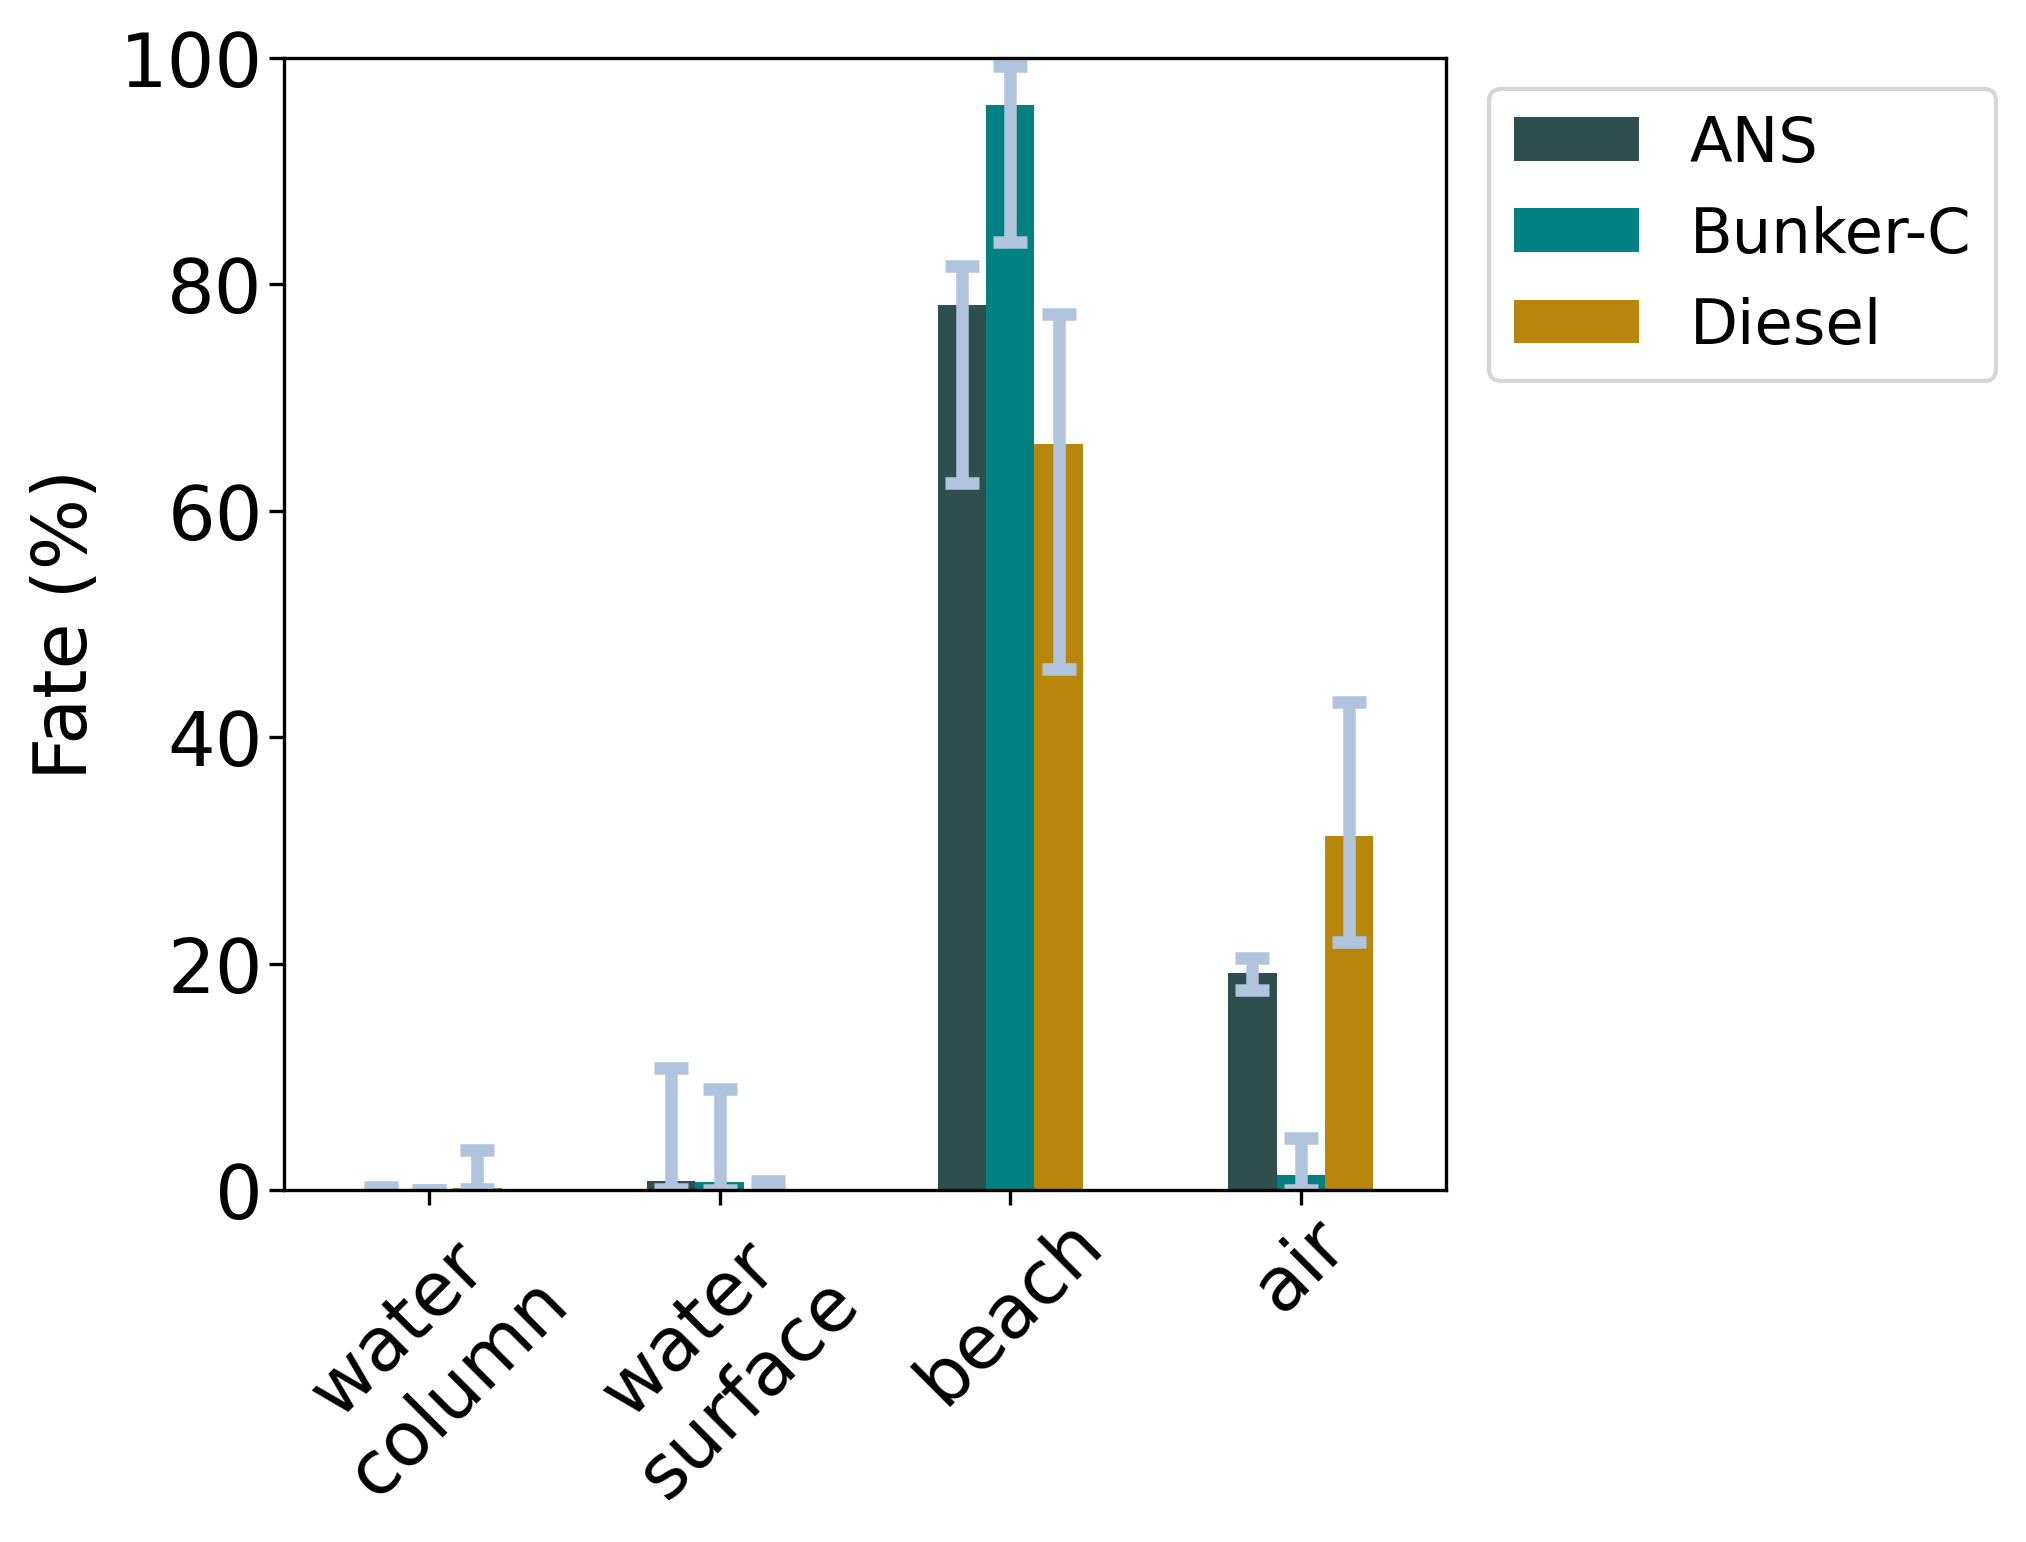

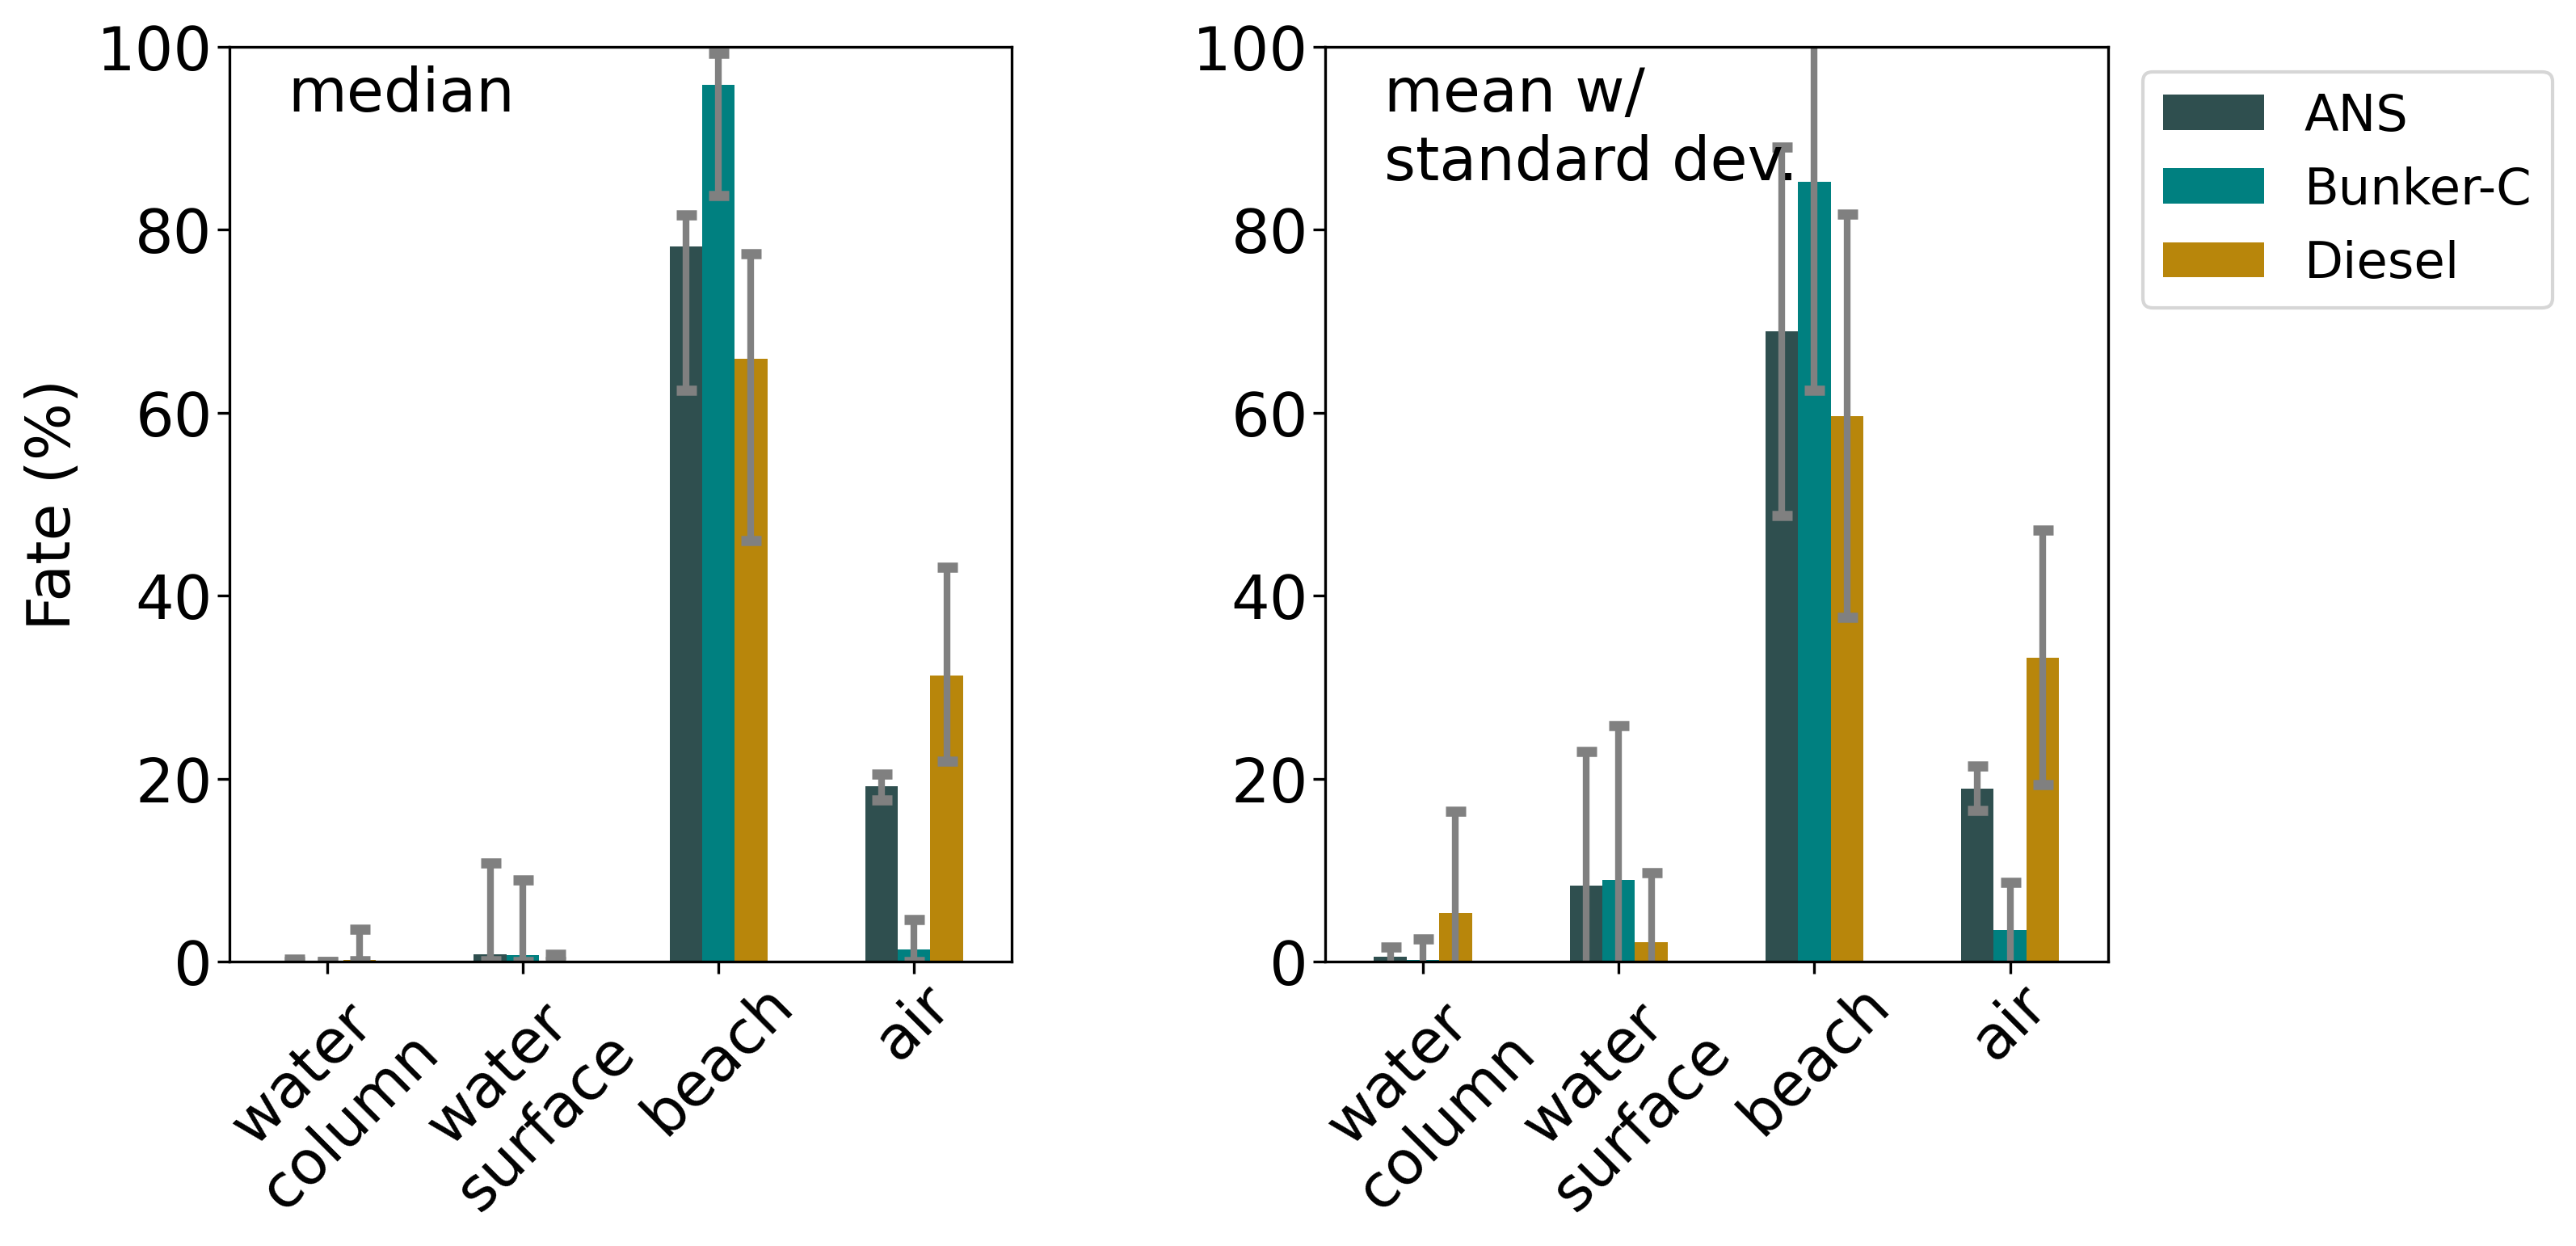

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1],
                       'wspace': 0.4,
                       'hspace': 0.2})
persist_df['median'].plot(ax=ax,
    kind="bar",
    color=[MIDOSScolors["ANS"],MIDOSScolors["Bunker-C"],MIDOSScolors["Diesel"]],
    legend=False,          
    yerr=yerr_reorg, #np.append(error_max, error_min, axis=0), 
    error_kw=dict(lw=3, capsize=4, capthick=3),
    ecolor='lightsteelblue'
)
ax.set_ylabel("Fate (%)")
ax.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
ax.set_ylim(0,100)
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xticklabels(
    ["water\ncolumn", "water\nsurface", "beach", "air"],
    rotation=45
)

plt.savefig(graphics_dir/'Fate_ByOilLocation_1panel_MedianErr.png')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ~~~ 2nd graphic: Panel 1 ~~~'

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5),
                       gridspec_kw={
                           'width_ratios': [1,1],
                           'height_ratios': [1],
                       'wspace': 0.4,
                       'hspace': 0.2})
persist_df['median'].plot(ax=ax[0],
    kind="bar",
    color=[MIDOSScolors["ANS"],MIDOSScolors["Bunker-C"],MIDOSScolors["Diesel"]],
    legend=False,          
    yerr=yerr_reorg,#np.append(error_min,error_max, axis=0),
    error_kw=dict(lw=2, capsize=3, capthick=3),
    ecolor='grey'
)

# ~~~ 2nd graphic: Panel 2 ~~~'
error = [[persist['std']["ANS"]["water"],persist['std']["ANS"]["sfc"],persist['std']["ANS"]["beach"],persist['std']["ANS"]["air"]],
         [persist['std']["Bunker-C"]["water"],persist['std']["Bunker-C"]["sfc"],persist['std']["Bunker-C"]["beach"],persist['std']["Bunker-C"]["air"]],
         [persist['std']["Diesel"]["water"],persist['std']["Diesel"]["sfc"],persist['std']["Diesel"]["beach"],persist['std']["Diesel"]["air"]]
]
persist_df['mean'].plot(ax=ax[1],
    kind="bar",
    color=[MIDOSScolors["ANS"],MIDOSScolors["Bunker-C"],MIDOSScolors["Diesel"]],
    yerr=error, 
    error_kw=dict(lw=2, capsize=3, capthick=3),
    ecolor='grey')
ax[0].set_ylabel("Fate (%)")
ax[0].text(-0.2,98,'median', va='top')
ax[1].legend(bbox_to_anchor=(1.6, 1), loc='upper right')
ax[1].text(-0.2,98,'mean w/\nstandard dev.', va="top")
for ind in [0,1]:
    ax[ind].set_ylim(0,100)
    ax[ind].set_yticks([0, 20, 40, 60, 80, 100])
    ax[ind].set_xticklabels(
        ["water\ncolumn", "water\nsurface", "beach", "air"],
        rotation=45
    )

plt.savefig(graphics_dir/'persistence_2panel.png')

## Plot persistence as a mean of all persistence fraction across all runs, with standard deviaion as error

In [36]:
# plotdata = pd.DataFrame({
#     "ANS":[persist_mean["ANS"]["water"], persist_mean["ANS"]["sfc"], persist_mean["ANS"]["beach"], persist_mean["ANS"]["air"]],
#     "Bunker-C":[persist_mean["Bunker-C"]["water"], persist_mean["Bunker-C"]["sfc"], persist_mean["Bunker-C"]["beach"], persist_mean["Bunker-C"]["air"]],
#     "Diesel":[persist_mean["Diesel"]["water"], persist_mean["Diesel"]["sfc"], persist_mean["Diesel"]["beach"], persist_mean["Diesel"]["air"]]
#     }, 
#     index=["water\ncolumn", "water\nsurface", "beach", "air"]
# )
# error = [[persist_std["ANS"]["water"],persist_std["ANS"]["sfc"],persist_std["ANS"]["beach"],persist_std["ANS"]["air"]],
#          [persist_std["Bunker-C"]["water"],persist_std["Bunker-C"]["sfc"],persist_std["Bunker-C"]["beach"],persist_std["Bunker-C"]["air"]],
#          [persist_std["Diesel"]["water"],persist_std["Diesel"]["sfc"],persist_std["Diesel"]["beach"],persist_std["Diesel"]["air"]]
# ]
# ax=plotdata.plot(
#     kind="bar",
#     color=[MIDOSScolors["ANS"],MIDOSScolors["Bunker-C"],MIDOSScolors["Diesel"]],
#     yerr=error)
# plt.title("Oil fate by oil type and location")
# #plt.xlabel("Location of oil")
# plt.xticks(rotation=45)
# plt.ylabel("Persistence Fraction")
# plt.yscale("linear")
# plt.ylim(0,1.1)
# plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
# #ax.set_yticklabels([0.0001, 0.001, 0.01, 0.1, 1.0])
# plt.savefig(graphics_dir/'persistence_asMean_1panel_linear.png')

### Add the mean values to above graphic

In [37]:
# first, remove dilbit
for location in locations:
    mean[location].pop('Dilbit')

## Plot histograms

In [38]:
# This time, save arrays by oil type
water_col = {}
surface = {}
beached = {}
evaporated = {}
for oil in oil_types:
    print(oil)
    # number of spills with positive dissolution (note: for Bunker but applied to all)
    water_col[oil] = (df[oil]['MDispersed'].loc[df[oil]['MDissolved']>0] + 
        df[oil]['MDissolved'].loc[df[oil]['MDissolved']>0] + 
        df[oil]['MBio'].loc[df[oil]['MDissolved']>0])
    # remove values associated with bogus dissolution/evaporation/surface
    surface[oil] = df[oil]['MassOil'].loc[df[oil]['MDissolved']>0]
    beached[oil] = df[oil]['MBeached'].loc[df[oil]['MDissolved']>0]
    evaporated[oil] = df[oil]['MEvaporated'].loc[df[oil]['MDissolved']>0]

ANS
Bunker-C
Diesel
Dilbit


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


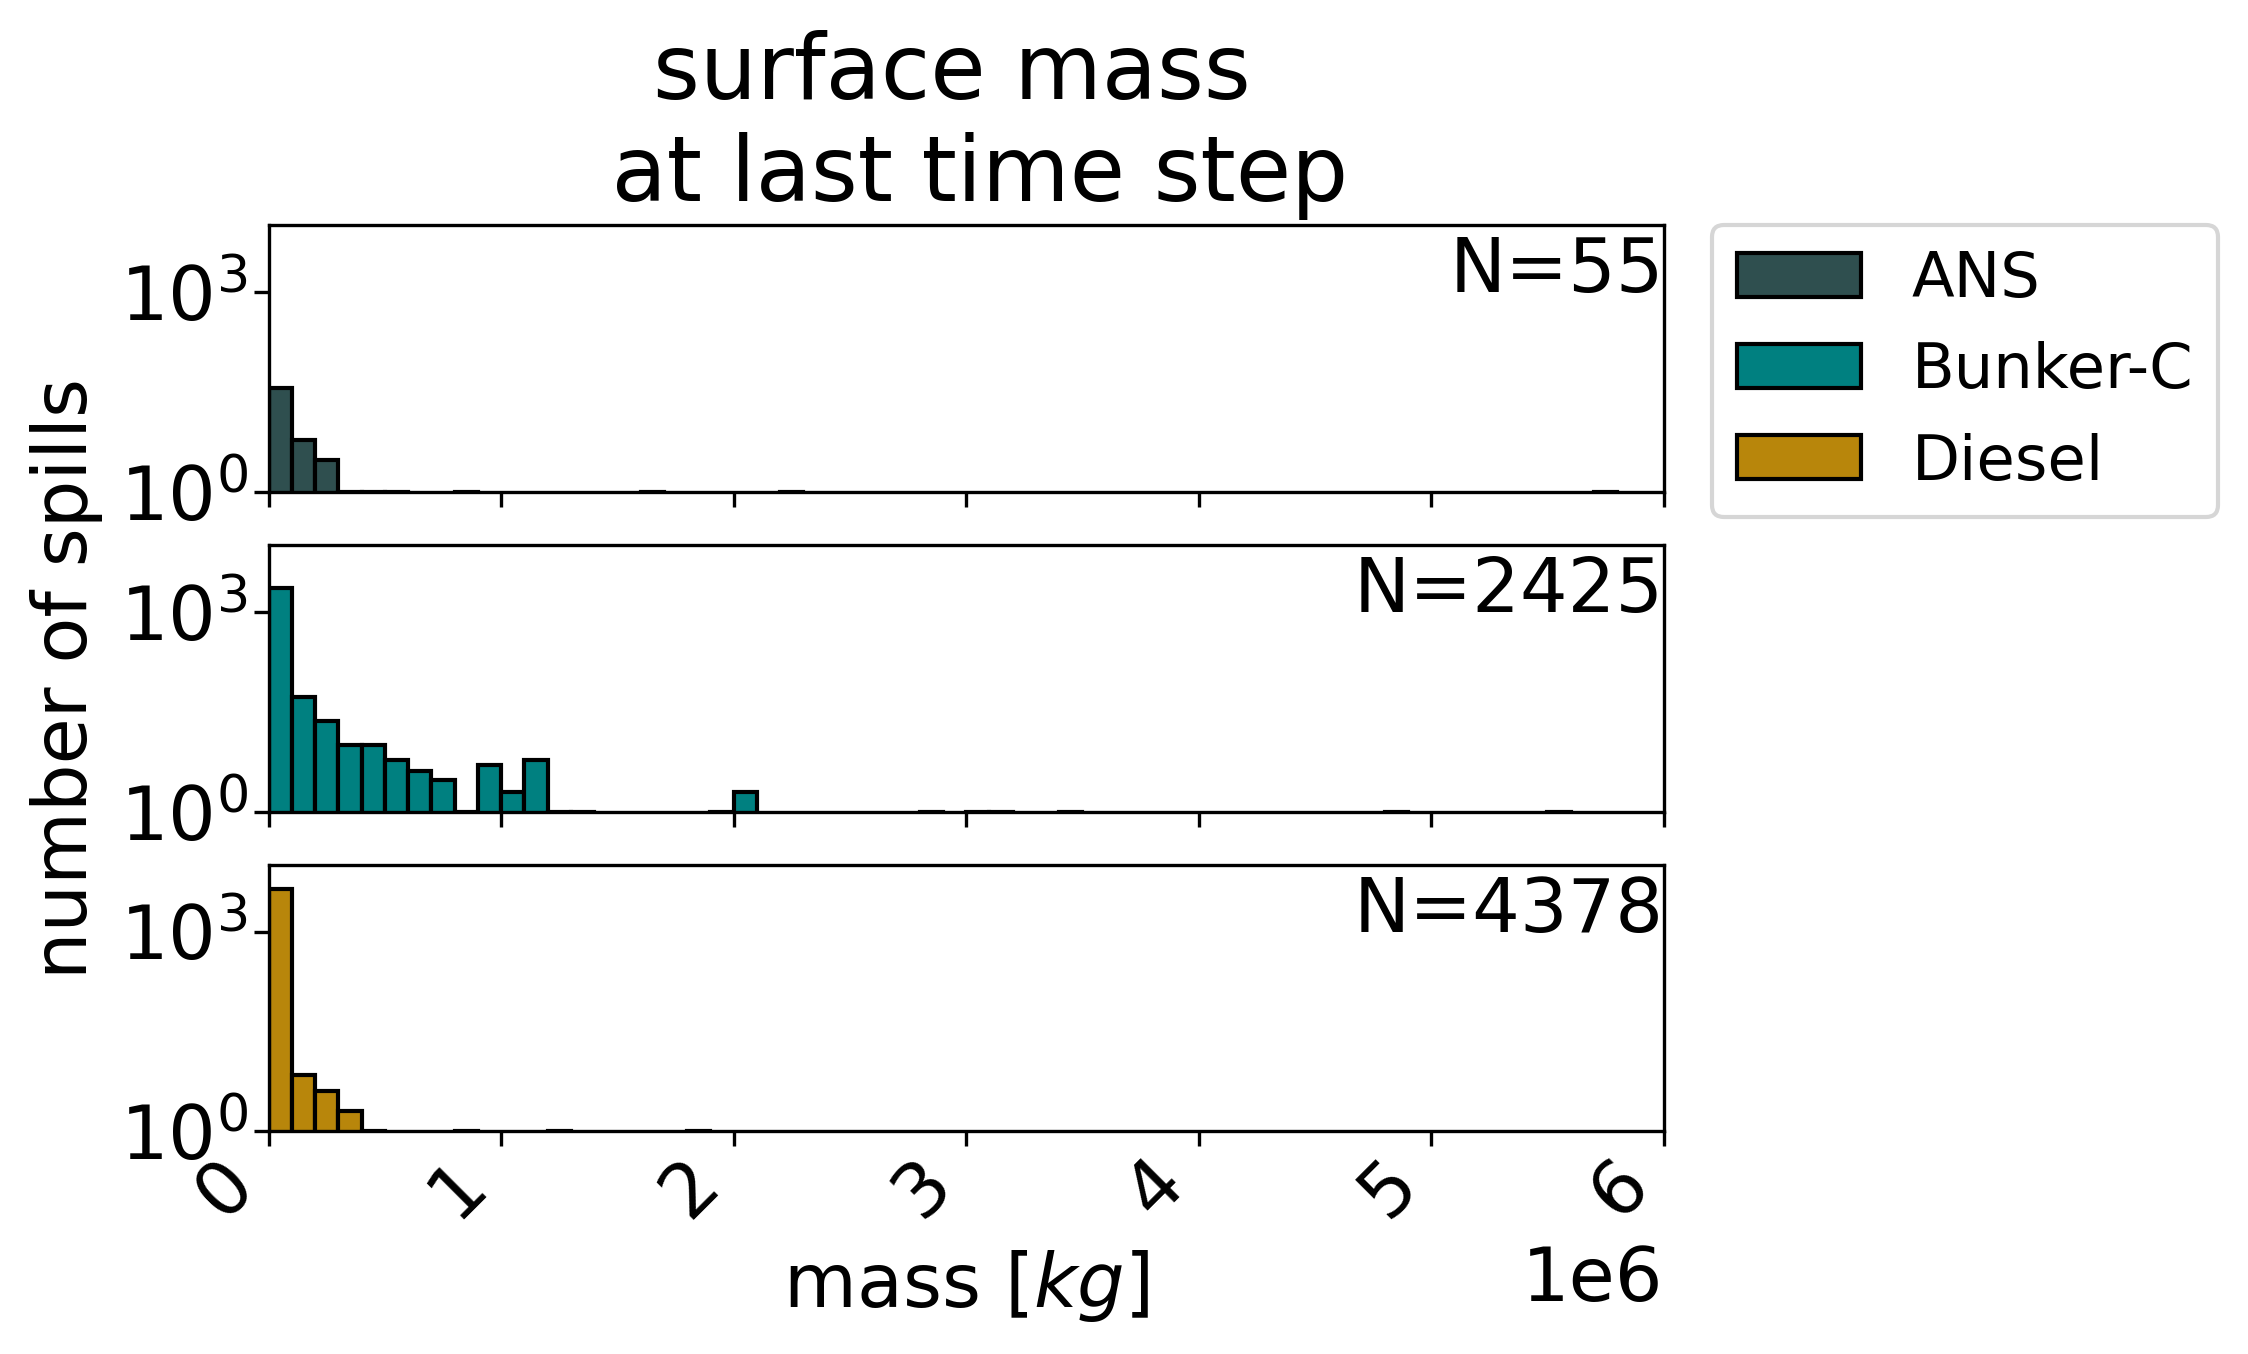

In [39]:
ylim = (0,1e4)
fig = plt.figure(1)
#ax = fig.add_subplot(1,1,1)
for idx,oil in enumerate(['ANS','Bunker-C','Diesel']):
    ax = fig.add_subplot(3,1,idx+1)
    n, bins, patches = plt.hist(
        numpy.asarray(surface[oil]),
        color=MIDOSScolors[oil],
        edgecolor='black',
        alpha=1,
        log=True,
        bins=numpy.arange(0,6e6+.1e6,.1e6),
        label=oil
    )
    ax.text(6e6,1e3,f'N={len(surface[oil])}',ha='right',fontsize='medium')
    plt.xlim(0,.6e7)
    plt.ylim(1e0,1e4)
    #ax.set_yticklabels([1e0,1e2,1e4])
    #plt.legend(bbox_to_anchor=(0.5, .8),loc=1)
    lines_sub, labels_sub = ax.get_legend_handles_labels()
    if idx==0:
        plt.title('surface mass \n at last time step')
        lines = lines_sub
        labels = labels_sub
    else:
        lines += lines_sub
        labels += labels_sub
    if idx==1:
        plt.ylabel('number of spills')
    if idx < 2:
        ax.set_xticklabels('')

plt.xlabel('mass [$kg$]')
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.legend(lines, labels, bbox_to_anchor=(1.42, 3.52),loc=1)
plt.savefig(graphics_dir/'SurfaceMassHistogram_ByOil_3panel.png')

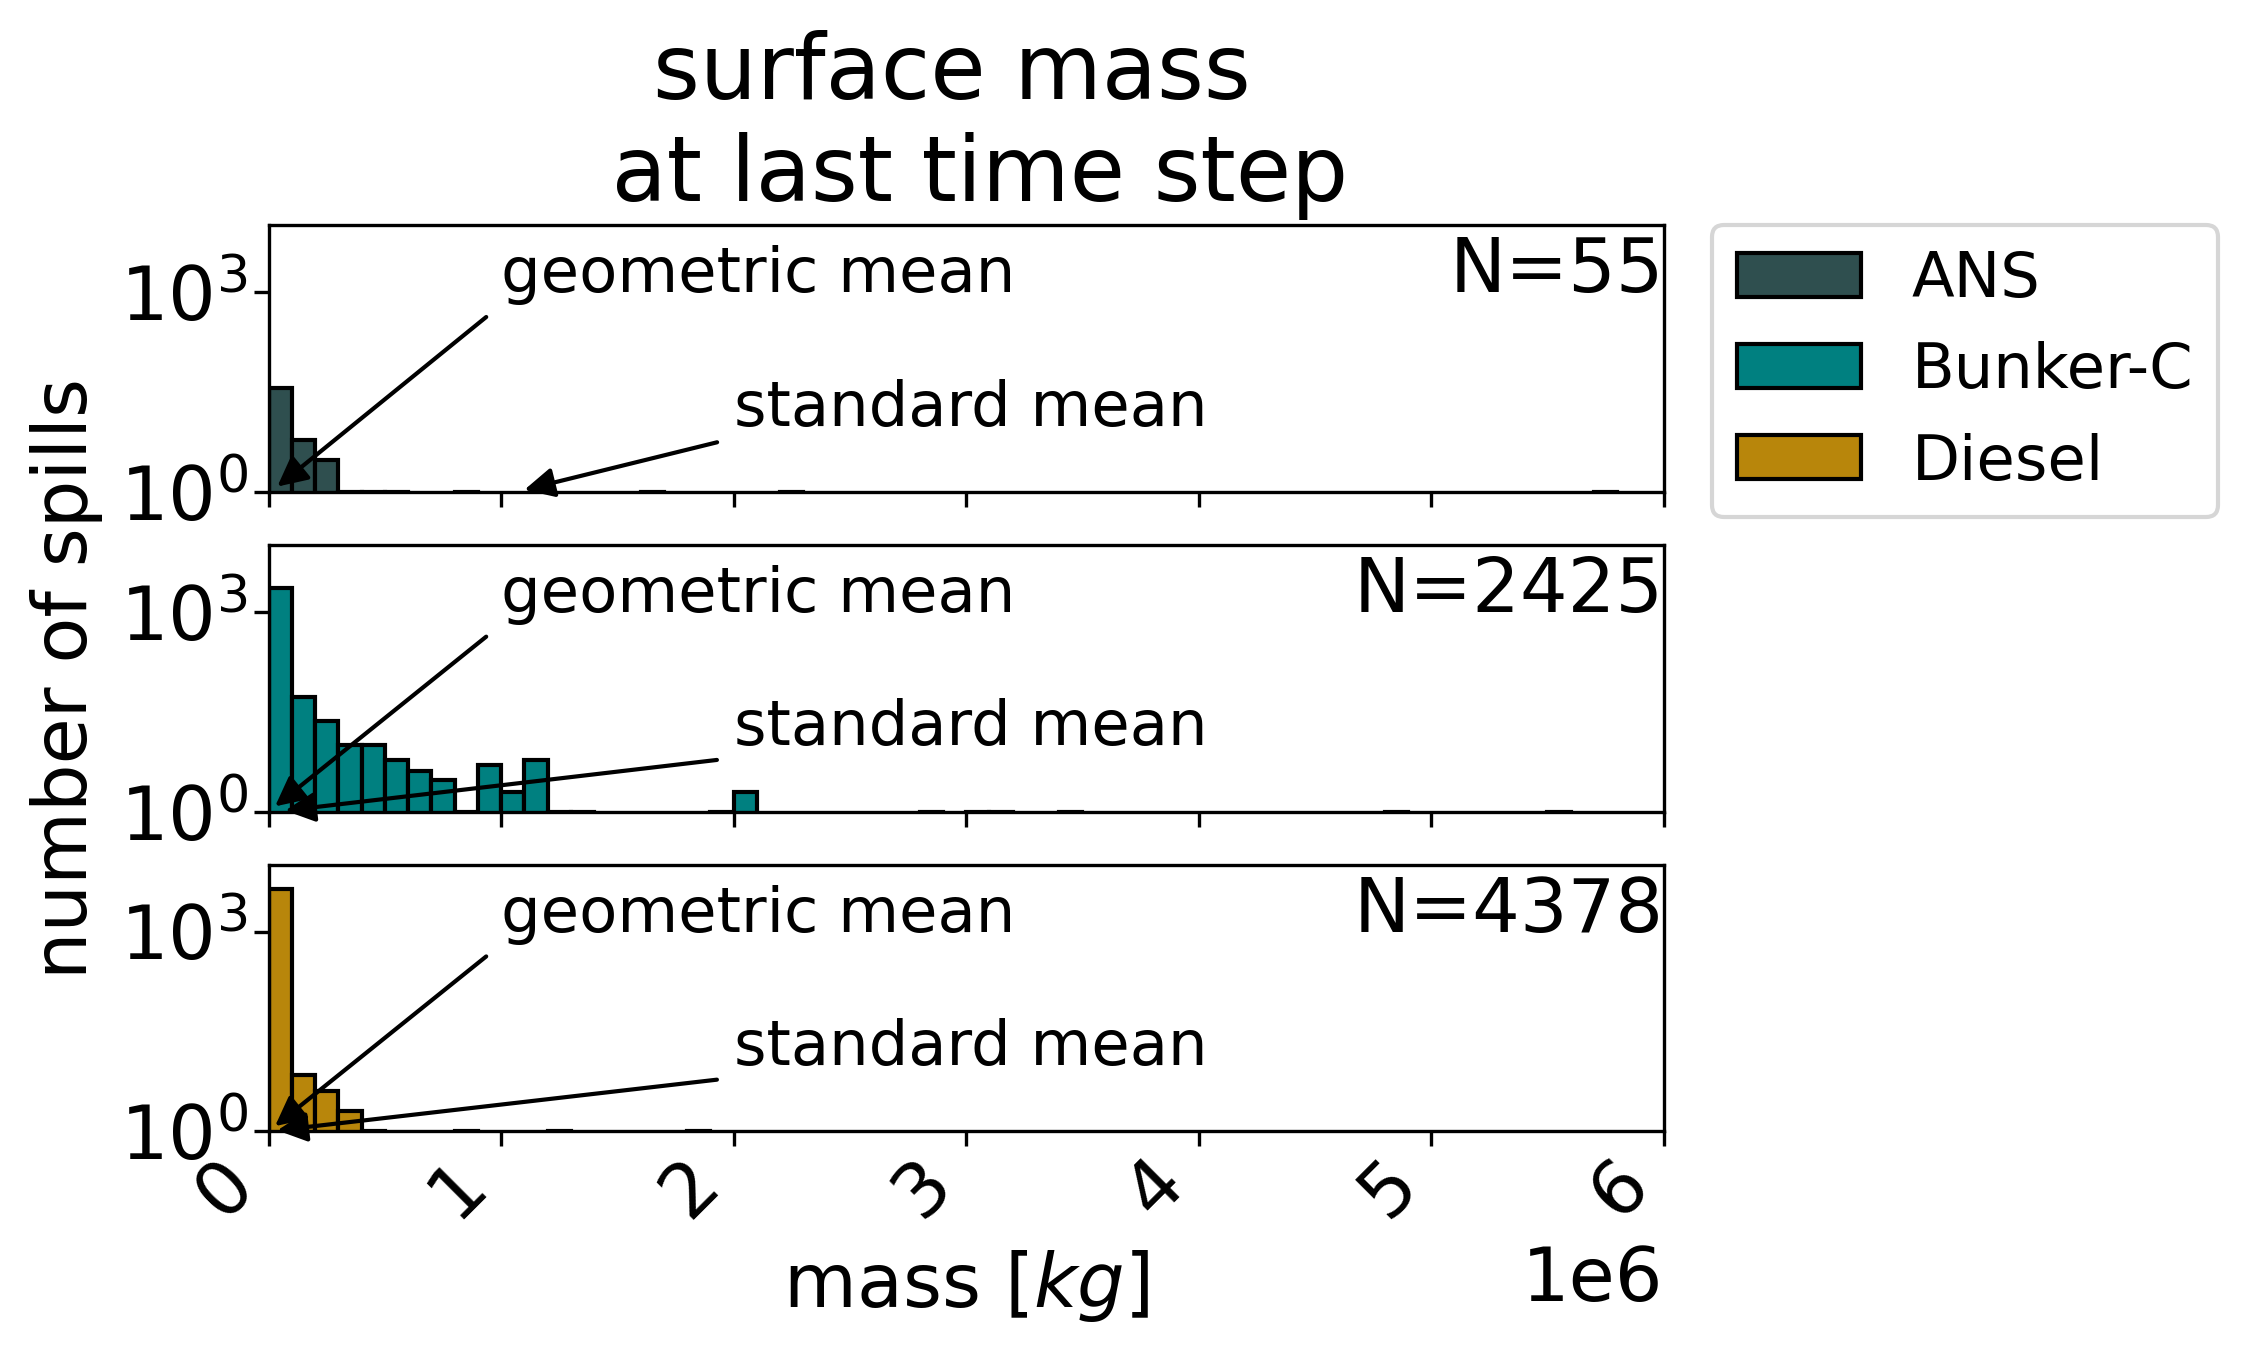

In [40]:
ylim = (0,1e4)
fig = plt.figure(1)
#ax = fig.add_subplot(1,1,1)
for idx,oil in enumerate(['ANS','Bunker-C','Diesel']):
    ax = fig.add_subplot(3,1,idx+1)
    n, bins, patches = plt.hist(
        numpy.asarray(surface[oil]),
        color=MIDOSScolors[oil],
        edgecolor='black',
        alpha=1,
        log=True,
        bins=numpy.arange(0,6e6+.1e6,.1e6),
        label=oil
    )
    #plt.text(mean['sfc'][oil],1e0,'standard',rotation=45)
    ax.annotate("standard mean", fontsize = "small",
            xy=(mean['sfc'][oil],1e0), xycoords='data',
            xytext=(2e6, 1e1), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",
                            facecolor='black',
                            connectionstyle="arc3",
                           relpos=(0,0)),
            )
    ax.annotate("geometric mean", fontsize = "small",
            xy=(sfc[oil],1e0), xycoords='data',
            xytext=(1e6, 1e3), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",
                            facecolor='black',
                            connectionstyle="arc3",
                           relpos=(0,0)),
            )
    ax.text(6e6,1e3,f'N={len(surface[oil])}',ha='right',fontsize='medium')
    plt.xlim(0,.6e7)
    plt.ylim(1e0,1e4)
    #ax.set_yticklabels([1e0,1e2,1e4])
    #plt.legend(bbox_to_anchor=(0.5, .8),loc=1)
    lines_sub, labels_sub = ax.get_legend_handles_labels()
    if idx==0:
        plt.title('surface mass \n at last time step')
        lines = lines_sub
        labels = labels_sub
    else:
        lines += lines_sub
        labels += labels_sub
    if idx==1:
        plt.ylabel('number of spills')
    if idx < 2:
        ax.set_xticklabels('')

plt.xlabel('mass [$kg$]')
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.legend(lines, labels, bbox_to_anchor=(1.42, 3.52),loc=1)
plt.savefig(graphics_dir/'SurfaceMassHistogram_ByOil_3panel_annotated.png')

## beached mass

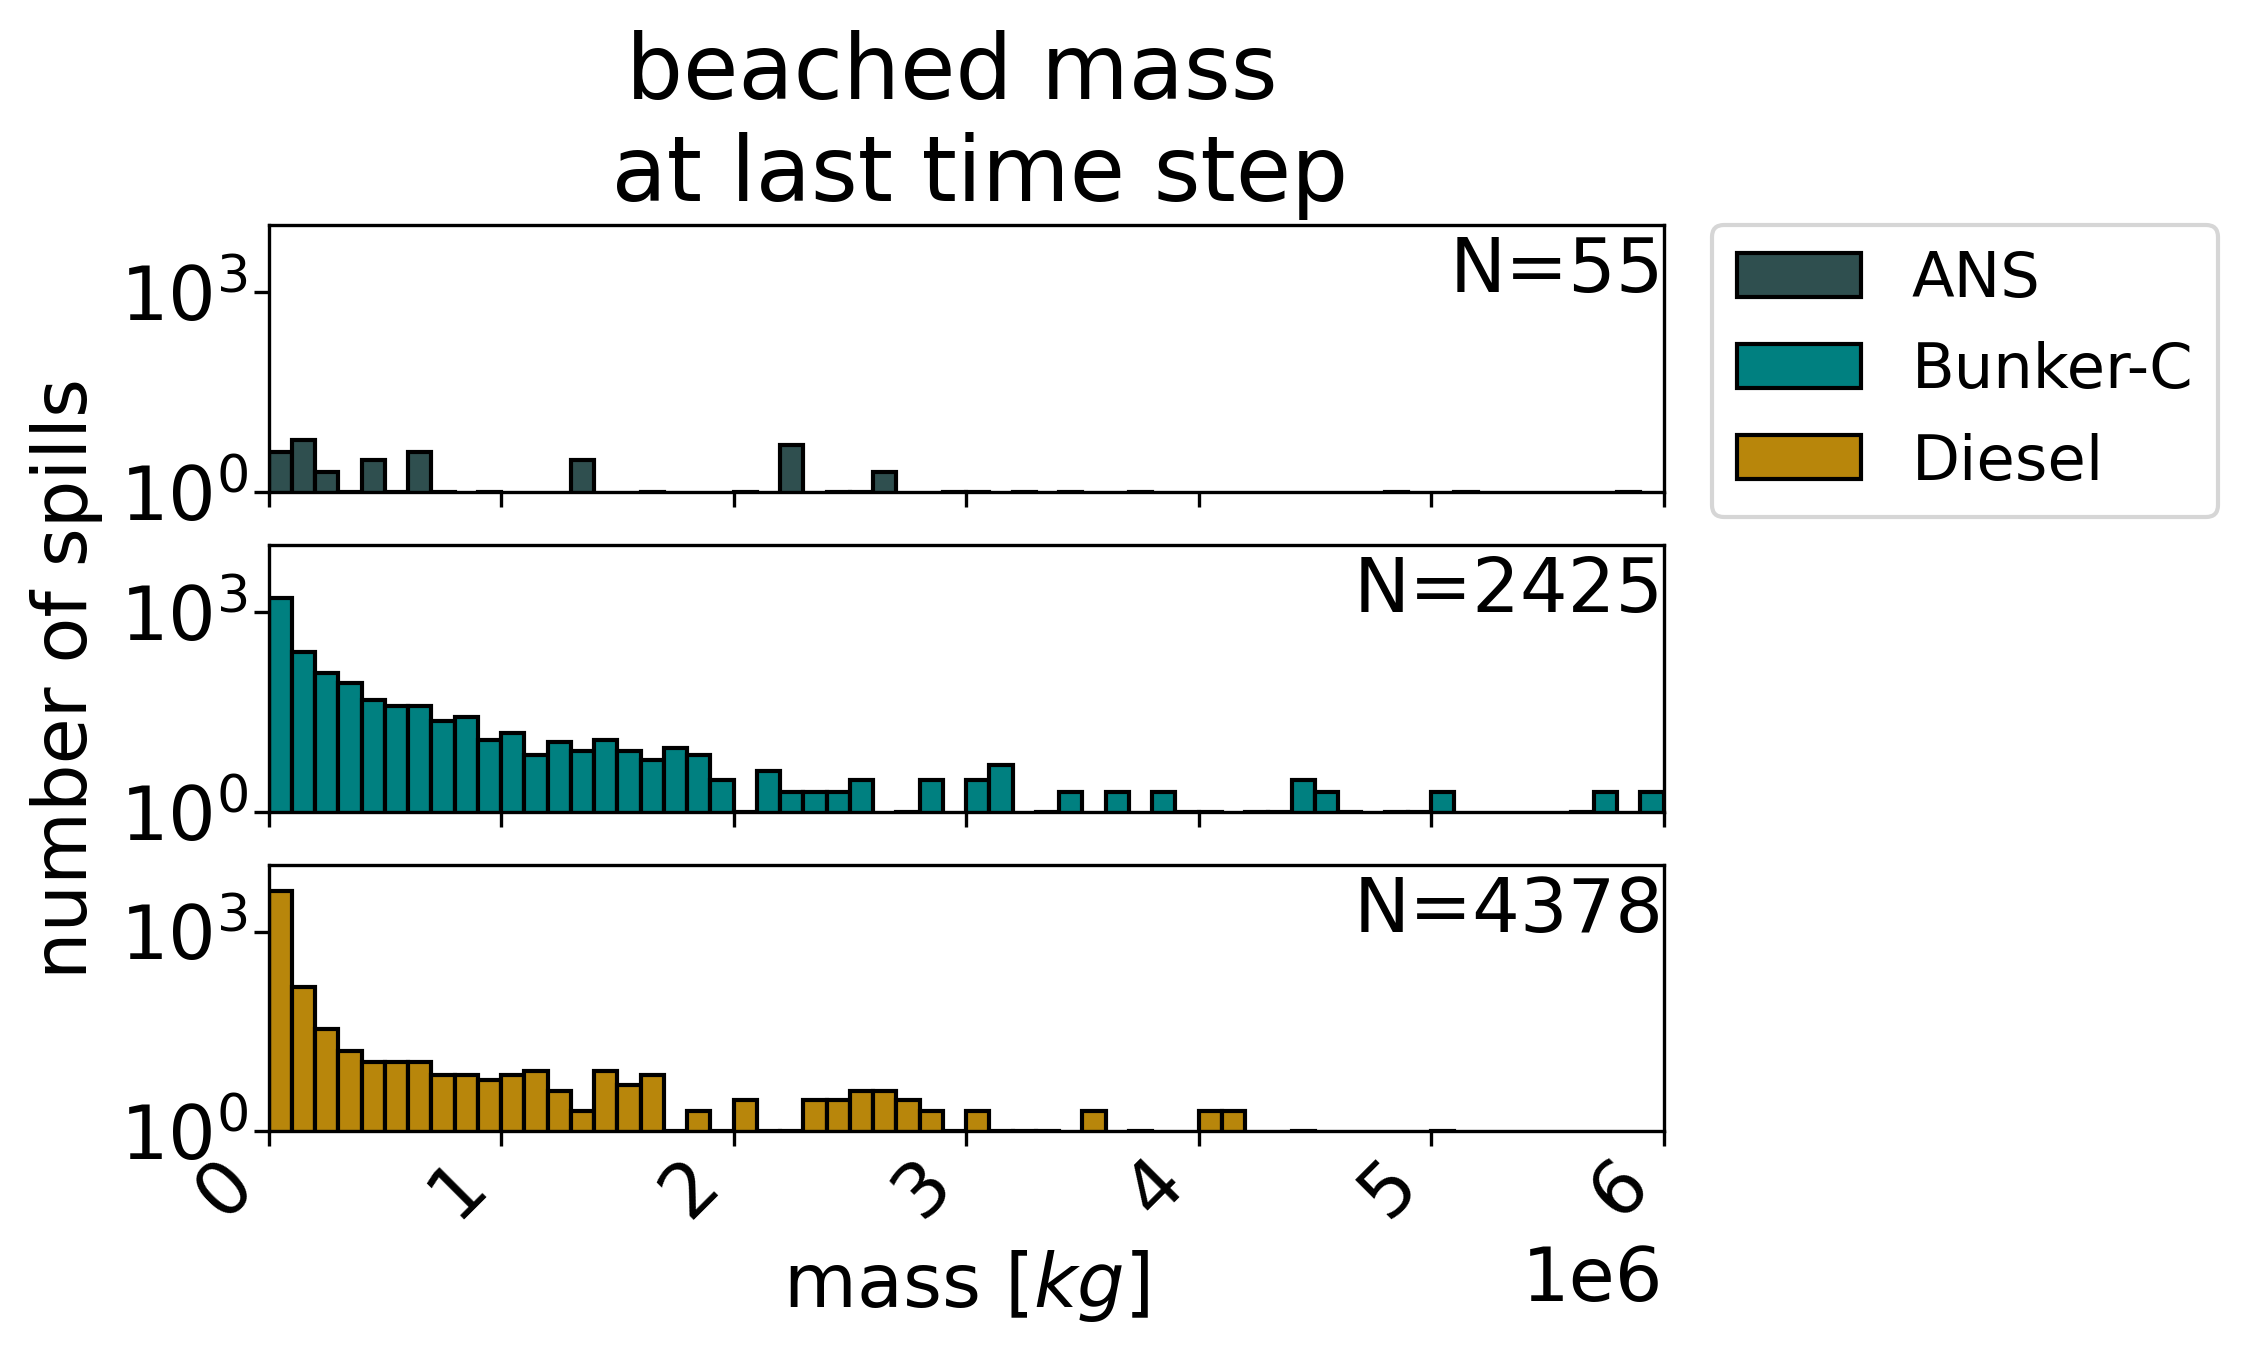

In [41]:
lim = (0,1e4)
fig = plt.figure(1)
#ax = fig.add_subplot(1,1,1)
for idx,oil in enumerate(['ANS','Bunker-C','Diesel']):
    ax = fig.add_subplot(3,1,idx+1)
    n, bins, patches = plt.hist(
        numpy.asarray(beached[oil]),
        color=MIDOSScolors[oil],
        edgecolor='black',
        alpha=1,
        log=True,
        bins=numpy.arange(0,6e6+.1e6,.1e6),
        label=oil
    )
    ax.text(6e6,1e3,f'N={len(beached[oil])}',ha='right',fontsize='medium')
    plt.xlim(0,.6e7)
    plt.ylim(1e0,1e4)
    #ax.set_yticklabels([1e0,1e2,1e4])
    #plt.legend(bbox_to_anchor=(0.5, .8),loc=1)
    lines_sub, labels_sub = ax.get_legend_handles_labels()
    if idx==0:
        plt.title('beached mass \n at last time step')
        lines = lines_sub
        labels = labels_sub
    else:
        lines += lines_sub
        labels += labels_sub
    if idx==1:
        plt.ylabel('number of spills')
    if idx < 2:
        ax.set_xticklabels('')

plt.xlabel('mass [$kg$]')
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.legend(lines, labels, bbox_to_anchor=(1.42, 3.52),loc=1)
plt.savefig(graphics_dir/'BeachedMassHistogram_ByOil_3panel.png')

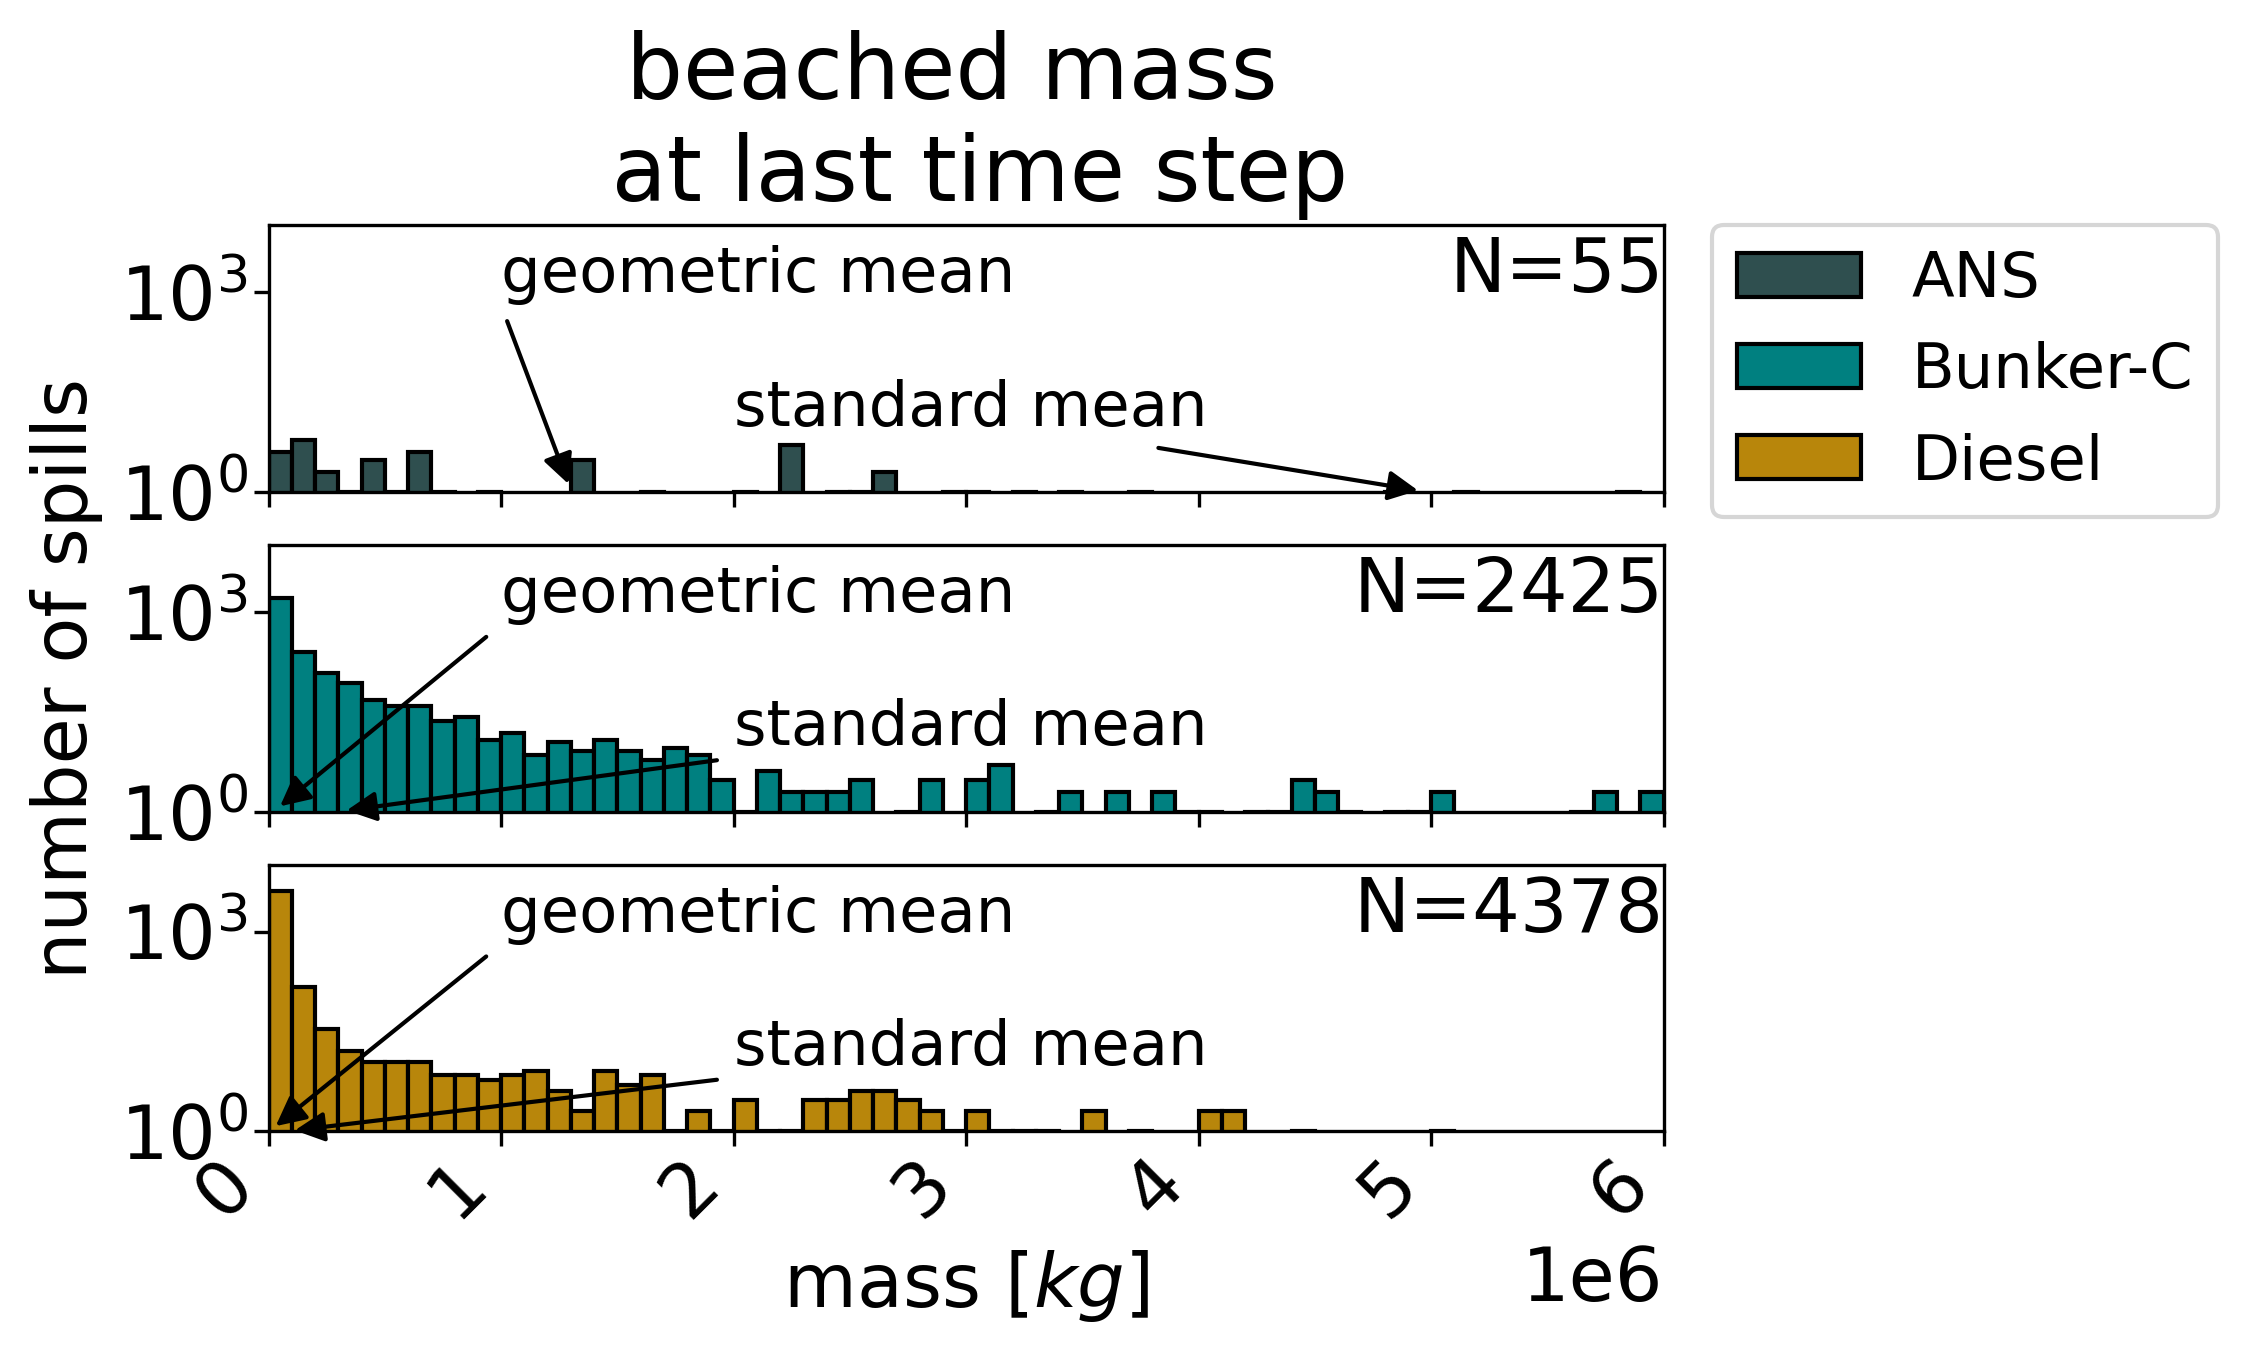

In [42]:
ylim = (0,1e4)
fig = plt.figure(1)
#ax = fig.add_subplot(1,1,1)
for idx,oil in enumerate(['ANS','Bunker-C','Diesel']):
    ax = fig.add_subplot(3,1,idx+1)
    n, bins, patches = plt.hist(
        numpy.asarray(beached[oil]),
        color=MIDOSScolors[oil],
        edgecolor='black',
        alpha=1,
        log=True,
        bins=numpy.arange(0,6e6+.1e6,.1e6),
        label=oil
    )
    if idx==0:
        ax.annotate("standard mean", fontsize = "small",
                xy=(mean['beach'][oil],1e0), xycoords='data',
                xytext=(2e6, 1e1), textcoords='data',
                arrowprops=dict(arrowstyle="-|>",
                                facecolor='black',
                                connectionstyle="arc3",
                               relpos=(0,1)),
                )
    else:
        ax.annotate("standard mean", fontsize = "small",
            xy=(mean['beach'][oil],1e0), xycoords='data',
            xytext=(2e6, 1e1), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",
                            facecolor='black',
                            connectionstyle="arc3",
                           relpos=(0,0)),
            )
    ax.annotate("geometric mean", fontsize = "small",
            xy=(beach[oil],1e0), xycoords='data',
            xytext=(1e6, 1e3), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",
                            facecolor='black',
                            connectionstyle="arc3",
                           relpos=(0,0)),
            )
    ax.text(6e6,1e3,f'N={len(beached[oil])}',ha='right',fontsize='medium')
    plt.xlim(0,.6e7)
    plt.ylim(1e0,1e4)
    #ax.set_yticklabels([1e0,1e2,1e4])
    #plt.legend(bbox_to_anchor=(0.5, .8),loc=1)
    lines_sub, labels_sub = ax.get_legend_handles_labels()
    if idx==0:
        plt.title('beached mass \n at last time step')
        lines = lines_sub
        labels = labels_sub
    else:
        lines += lines_sub
        labels += labels_sub
    if idx==1:
        plt.ylabel('number of spills')
    if idx < 2:
        ax.set_xticklabels('')

plt.xlabel('mass [$kg$]')
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.legend(lines, labels, bbox_to_anchor=(1.42, 3.52),loc=1)
plt.savefig(graphics_dir/'BeachedMassHistogram_ByOil_3panel_annotated.png')